![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [229]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from itertools import combinations
from scipy.stats import ttest_ind
import statsmodels.api as sm
import scipy.stats as sst
from collections import Counter
import re

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

#для анализа тональности отзыва
from textblob import TextBlob

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

filenames_list = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        filenames_list.append(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import datetime

Methods

In [230]:
# Функция для округления рейтинга
def find_item(cell):
    if item in cell:
        return 1
    return 0
def round_of_rating(number):
    return np.round(number * 2) / 2

In [231]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [232]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [112]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [113]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [114]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [115]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [116]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [117]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [118]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [233]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [121]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
19366,id_4405,Milan,NaN,4408.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187849-d12388483-Reviews-B...,d12388483,1,4.0
24440,id_3325,Milan,"['Chinese', 'Asian']",3327.0,$,41.0,"[['OK', 'Good Authentic Chinese Food'], ['02/0...",/Restaurant_Review-g187849-d1522960-Reviews-Tr...,d1522960,1,4.0
29885,id_3137,London,"['Italian', 'Pizza', 'Mediterranean', 'Europea...",3143.0,$$ - $$$,94.0,"[['Good and nice service', 'Best Pizza ever in...",/Restaurant_Review-g186338-d10470893-Reviews-S...,d10470893,1,4.5
38301,id_190,Luxembourg,"['French', 'European']",191.0,$$ - $$$,56.0,"[['Authentique pleasure!', 'A little gem!'], [...",/Restaurant_Review-g190356-d4786771-Reviews-Br...,d4786771,1,4.0
34592,id_76,Lyon,"['French', 'Wine Bar']",77.0,$$ - $$$,178.0,"[['A Gem', 'Like Wine Tasting at Home'], ['07/...",/Restaurant_Review-g187265-d6575602-Reviews-Bm...,d6575602,1,4.5


In [122]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

In [234]:
# Завернем модель в функцию для того, чтобы было удобнее вызывать

def model_func(df_preproc):
    # выделим тестовую часть
    train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
    test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

    y = train_data.Rating.values            # наш таргет
    X = train_data.drop(['Rating'], axis=1)
    
    RANDOM_SEED = 42
    
    # Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
    # выделим 20% данных на валидацию (параметр test_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

    # Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
    model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
    
    # Обучаем модель на тестовом наборе данных
    model.fit(X_train, y_train)

    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
    # Предсказанные значения записываем в переменную y_pred
    y_pred = model.predict(X_test)
    y_pred = round_of_rating(y_pred)
    
    result = metrics.mean_absolute_error(y_test, y_pred)
    
    # в RandomForestRegressor есть возможность вывести самые важные признаки для модели
    plt.rcParams['figure.figsize'] = (5,5)
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(35).plot(kind='barh')
    
    plt.show
    
    return result

## 1. Обработка NAN 
Заполним пустые значения у фичи Number_of_reviews медианой

In [235]:
data['Number of Reviews'] = data['Number of Reviews'].fillna(data['Number of Reviews'].median())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


0.473125

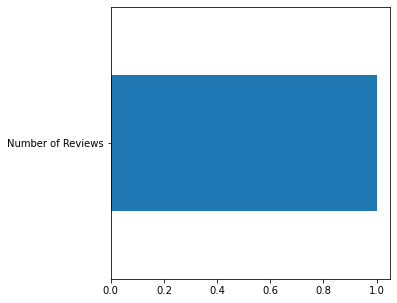

In [125]:
df_preproc = pd.concat(
    [data.loc[:, ['Rating', 'sample']], data['Number of Reviews']], axis=1)
model_func(df_preproc)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [126]:
data.nunique(dropna=False)

Restaurant_id        13094
City                    31
Cuisine Style        10732
Ranking              12975
Price Range              4
Number of Reviews     1573
Reviews              41858
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [127]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
cities = pd.get_dummies(data['City'], dummy_na=True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


0.500375

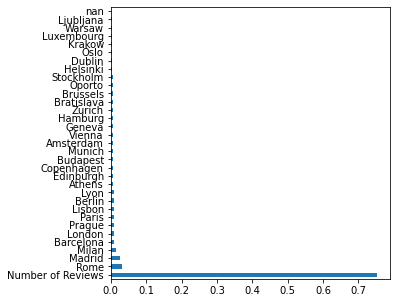

In [129]:
model_func(pd.concat([df_preproc,cities],axis=1))

Благодаря функци видим что одним из самых важных городов это мадрид и рим
Создадим эти колонки

In [130]:
data['Is_Rome']=data['City'].apply(lambda x: 1 if x == 'Rome' else 0)
data['is_Madrid'] = data['City'].apply(lambda x: 1 if x == 'Madrid' else 0)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


0.474

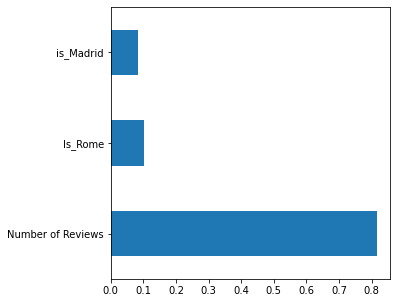

In [131]:
df_preproc = pd.concat([df_preproc,data[['is_Madrid','Is_Rome']]],axis=1)
model_func(df_preproc)

#### Возьмем следующий признак "Price Range".

In [132]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [133]:
# Ваша обработка 'Price Range'
data['Price Range'] = data['Price Range'].fillna('$$ - $$$')
data['Price Range'] = data['Price Range'].apply(
    lambda x: 2 if x == '$$ - $$$' else 1 if x == '$' else 3)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


0.471125

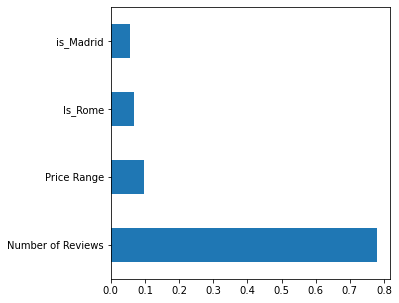

In [134]:
df_preproc=pd.concat([df_preproc,data['Price Range']],axis=1)
model_func(df_preproc)

**Cuisine Style**

In [135]:
# Cuisine Style приведем кузин стайл к нормальному виду
data['Cuisine Style'] = data['Cuisine Style'].apply(
    lambda x: str(x)[1:-1].replace("'", '') if not pd.isnull(x) else x)

In [136]:
# Заполняю нан значения кухонь значением other
data['Cuisine Style'] = data['Cuisine Style'].fillna('Other')

In [137]:
# Сет из набора кухонь
set_cuisine = set()

In [138]:
# заполняем наш сет
data['Cuisine Style'].apply(
    lambda x: [set_cuisine.add(x) for x in str(x).split(', ')])

0                                [None, None]
1              [None, None, None, None, None]
2                                      [None]
3              [None, None, None, None, None]
4        [None, None, None, None, None, None]
                         ...                 
49995                [None, None, None, None]
49996          [None, None, None, None, None]
49997                            [None, None]
49998          [None, None, None, None, None]
49999                                  [None]
Name: Cuisine Style, Length: 50000, dtype: object

In [139]:
len(set_cuisine)

126

In [140]:
#Создаем столбцы с кухнями 
for i in set_cuisine:
    data[i]=data['Cuisine Style'].apply(lambda x: 1 if i in str(x).split(', ') else 0)

In [141]:
# Кол-во кухонь в ресторане
data['Count_Cuisine'] = data['Cuisine Style'].apply(
    lambda x: len(str(x).split(', ')))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


0.4849375

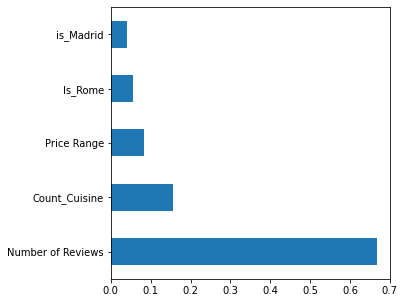

In [142]:
# результат не растет
df_preproc = pd.concat([df_preproc,data.loc[:,['Count_Cuisine']
 ]],axis=1)
model_func(df_preproc)

**Restaurant_id**

In [143]:
data['Restaurant_id'] = data.Restaurant_id.apply(lambda x: int(str(x[3:])))

In [144]:
df_preproc = pd.concat([df_preproc, data.loc[:,['Restaurant_id']]],axis=1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.359875

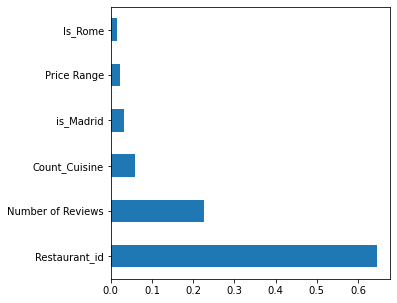

In [145]:
# удивительно как влияет id ведь казалось бы что здесь интересного
model_func(df_preproc)

**Ranking**

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.3519375

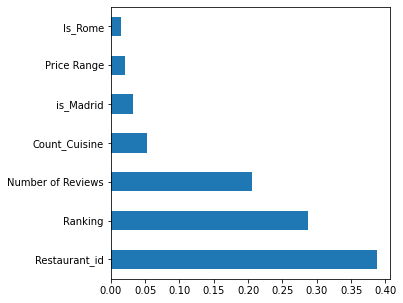

In [146]:
df_preproc = pd.concat([df_preproc, data.loc[:,['Ranking']]],axis=1)
model_func(df_preproc)

**Reviews**

In [147]:
data_rev = data.copy()
data_rev = data_rev[['Reviews']]

In [148]:
data_rev

,Reviews
0,"[[], []]"
1,"[['Very good reviews!', 'Fine dining in Hakani..."
2,"[['Better than the Links', 'Ivy Black'], ['12/..."
3,"[['Most exquisite', 'Delicious and authentic']..."
4,"[['Always the best in bratislava', 'Very good ..."
...,...
49995,"[['The real Italian experience!', 'Wonderful f..."
49996,"[['Parisian atmosphere', 'Bit pricey but inter..."
49997,"[['Good by swedish standards', 'A hidden jewel..."
49998,"[['Underground restaurant', 'Oldest Restaurant..."


In [236]:
def Reviews_class(row):
    row['feed_polarity1'] = TextBlob(str(row['Reviews']).split('],')[
                                     0][3:-1].split("', '")[0]).sentiment[0]
    row['feed_subjectivity1'] = TextBlob(str(row['Reviews']).split('],')[
                                         0][3:-1].split("', '")[0]).sentiment[1]
    if len(str(row['Reviews']).split('],')[0][3:-1]) > 1:
        row['feed_polarity2'] = TextBlob(str(row['Reviews']).split('],')[
                                         0][3:-1].split("', '")[0]).sentiment[0]
        row['feed_subjectivity2'] = TextBlob(str(row['Reviews']).split('],')[
                                             0][3:-1].split("', '")[0]).sentiment[1]

    else:
        row['feed_polarity2'] = 0
        row['feed_subjectivity2'] = 0

    return row

In [150]:
data_rev = data_rev.apply(Reviews_class,axis=1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.332375

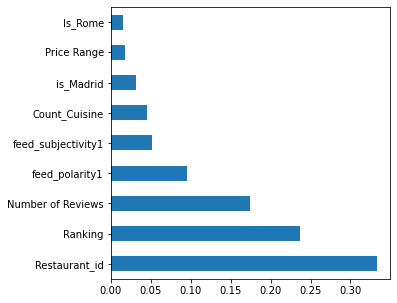

In [151]:
#Колонки выбраны путем подбора
df_preproc = pd.concat([df_preproc, data_rev.loc[:,['feed_polarity1','feed_subjectivity1']]],axis=1)
model_func(df_preproc)

**Работа со временем**


In [225]:
#Создаем паттерн для поиска времени в строке
pattern=re.compile('\d\d?/\d\d?/\d+')

Данная функция возвращает самое последнее время отзыва

In [237]:
def time(row):
    x = pattern.findall(str(row['Reviews']))
    # если существует одна дата в списке
    if len(x) == 1:
        row['last_rewiew'] = pd.to_datetime(x[0])
    # ищем самую позднюю дату ревью и заполняем им столбец
    elif len(x) > 1:
        row['last_rewiew'] = max(pd.to_datetime(x[0]), pd.to_datetime(x[1]))
    # у строки нет времени
    elif len(x) == 0:
        row['last_rewiew'] = np.nan

    return row

In [154]:
data = data.apply(time, axis=1)

In [155]:
# Заполним нан значения
data['last_rewiew'] = data['last_rewiew'].fillna(
    data['last_rewiew'].quantile())

In [156]:
# записываем в столбец кол-во дней прошедших с самой поздней даты в нашей выборке
data['last_rewiew'] = pd.to_timedelta(
    (max(data['last_rewiew'])-data['last_rewiew'])).apply(lambda x: x.days)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.3226875

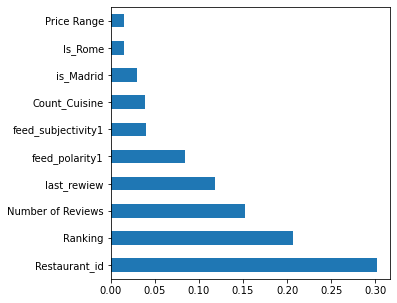

In [159]:
df_preproc= pd.concat([df_preproc, data.loc[:,['last_rewiew']]],axis=1)
model_func(df_preproc)

т.к городов не очень много составим словарь с доп информацией

In [238]:
сity_info = {
        'Munich':
        {
            'capital': 0,
            'population': 1456000,
            'numberofrestaraunts': 3018,
            'country': 'Germany'
        },
        'Oporto':
        {
            'capital': 0,
            'population': 214000,
            'numberofrestaraunts': 1902,
            'country': 'Portugal'
        },
        'Milan':
        {
            'capital': 0,
            'population': 1352000,
            'numberofrestaraunts': 7000,
            'country': 'Italy'
        },
        'Barcelona':
        {
            'capital': 0,
            'population': 5515000,
            'numberofrestaraunts': 9309,
            'country': 'Spain'
        },
        'Zurich':
        {
            'capital': 0,
            'population': 402000,
            'numberofrestaraunts': 1792,
            'country': 'Switzerland'
        },
        'Lyon':
        {
            'capital': 0,
            'population': 513000,
            'numberofrestaraunts': 2701,
            'country': 'France'
        },
        'Hamburg':
        {
            'capital': 0,
            'population': 1822000,
            'numberofrestaraunts': 3138,
            'country': 'Germany'
        },
        'Geneva':
        {
            'capital': 0,
            'population': 495000,
            'numberofrestaraunts': 1665,
            'country': 'Switzerland'
        },
        'Krakow':
        {
            'capital': 0,
            'population': 769000,
            'numberofrestaraunts': 1621,
            'country': 'Poland'
        },
        'Paris':
        {
            'capital': 1,
            'population': 2148000,
            'numberofrestaraunts': 16684,
            'country': 'France'
        },
        'Stockholm':
        {
            'capital': 1,
            'population': 974000,
            'numberofrestaraunts': 2882,
            'country': 'Sweden'
        },
        'London':
        {
            'capital': 1,
            'population': 8899000,
            'numberofrestaraunts': 19374,
            'country': 'England'
        },
        'Berlin':
        {
            'capital': 1,
            'population': 3748000,
            'numberofrestaraunts': 6962,
            'country': 'Germany'
        },
        'Bratislava':
        {
            'capital': 1,
            'population': 424000,
            'numberofrestaraunts': 1201,
            'country': 'Slovakia'
        },
        'Vienna':
        {
            'capital': 1,
            'population': 1889000,
            'numberofrestaraunts': 3951,
            'country': 'Austria'
        },
        'Rome':
        {
            'capital': 1,
            'population': 2873000,
            'numberofrestaraunts': 10558,
            'country': 'Italy'
        },
        'Madrid':
        {
            'capital': 1,
            'population': 6549000,
            'numberofrestaraunts': 10891,
            'country': 'Spain'
        },
        'Dublin':
        {
            'capital': 1,
            'population': 1361000,
            'numberofrestaraunts': 2298,
            'country': 'Ireland'
        },
        'Brussels':
        {
            'capital': 1,
            'population': 1831000,
            'numberofrestaraunts': 3525,
            'country': 'Belgium'
        },
        'Warsaw':
        {
            'capital': 1,
            'population': 1708000,
            'numberofrestaraunts': 3040,
            'country': 'Poland'
        },
        'Budapest':
        {
            'capital': 1,
            'population': 1750000,
            'numberofrestaraunts': 2917,
            'country': 'Hungary'
        },
        'Copenhagen':
        {
            'capital': 1,
            'population': 602000,
            'numberofrestaraunts': 2329,
            'country': 'Denmark'
        },
        'Amsterdam':
        {
            'capital': 1,
            'population': 821000,
            'numberofrestaraunts': 3847,
            'country': 'The Netherlands'
        },
        'Lisbon':
        {
            'capital': 1,
            'population': 504000,
            'numberofrestaraunts': 4682,
            'country': 'Portugal',
        },
        'Prague':
        {
            'capital': 1,
            'population': 1319000,
            'numberofrestaraunts': 5213,
            'country': 'The Czech Republic'
        },
        'Oslo':
        {
            'capital': 1,
            'population': 673000,
            'numberofrestaraunts': 1303,
            'country': 'Norway'
        },
        'Helsinki':
        {
            'capital': 1,
            'population': 631000,
            'numberofrestaraunts': 1478,
            'country': 'Finland'
        },
        'Edinburgh':
        {
            'capital': 1,
            'population': 488000,
            'numberofrestaraunts': 1852,
            'country': 'Scotland'
        },
        'Ljubljana':
        {
            'capital': 1,
            'population': 284000,
            'numberofrestaraunts': 583,
            'country': 'Slovenia'
        },
        'Athens':
            {'capital': 1,
            'population': 664000 ,
            'numberofrestaraunts': 2441,
            'country': 'Greece'
        },
        'Luxembourg':
        {
            'capital': 1,
            'population': 115000,
            'numberofrestaraunts': 716,
            'country': 'Luxembourg'}}

In [239]:
# функция заполняющая колонки доп информацией
def city_stats(row):
    row['is_capital'] = сity_info[row.City]['capital']
    row['population'] = сity_info[row.City]['population']
    row['numberofrestaraunts'] = сity_info[row.City]['numberofrestaraunts']
    row['country'] = сity_info[row.City]['country']
    return row

In [163]:
data = data.apply(city_stats,axis=1)

In [164]:
countries = pd.get_dummies(data['country'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1780625

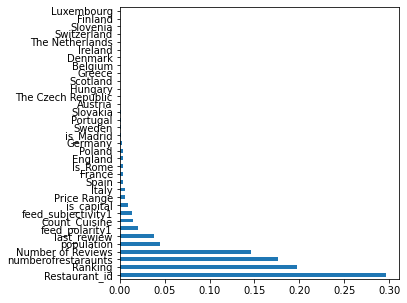

In [165]:
df_preproc = pd.concat([df_preproc,countries,data[['is_capital','population','numberofrestaraunts']]],axis=1)
model_func(df_preproc)

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

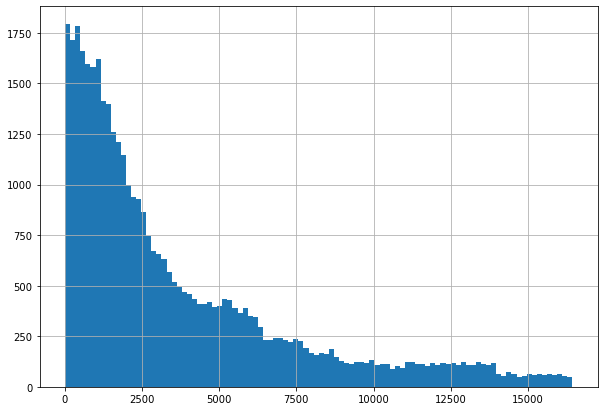

In [169]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

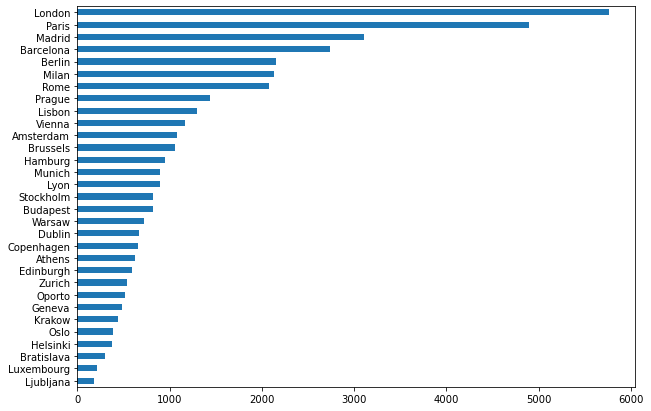

In [170]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

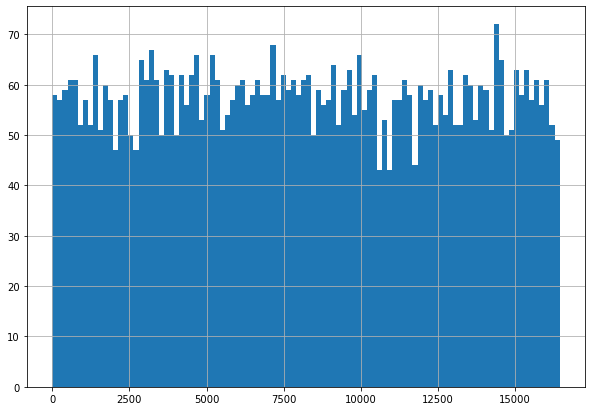

In [171]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

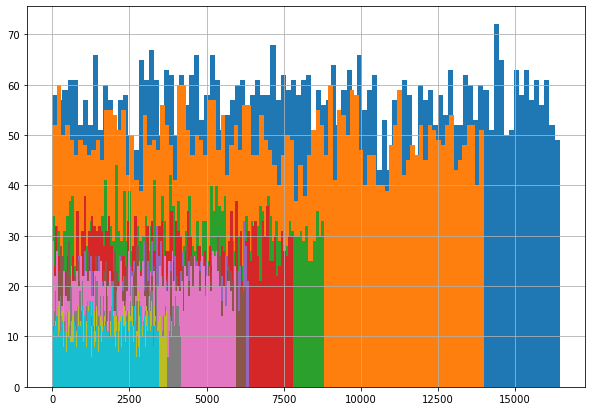

In [172]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Давай те стандартизируем ranking

In [173]:
mean_per_city = data.groupby('City')['Ranking'].mean()
data['mean_ranking_per_city'] = data['City'].apply(lambda x: mean_per_city[x])

#  масмимальный ранкинг для каждого города
max_per_city = data.groupby('City')['Ranking'].max()
data['max_per_city'] = data['City'].apply(lambda x: max_per_city[x])

# стандартизация
data['StandRanking'] = (data['Ranking'] - data['mean_ranking_per_city']) / data['max_per_city']

In [174]:
data.corr()

,Restaurant_id,Ranking,Price Range,Number of Reviews,ID_TA,sample,Rating,Is_Rome,is_Madrid,Fast Food,...,Welsh,Arabic,Count_Cuisine,last_rewiew,is_capital,population,numberofrestaraunts,mean_ranking_per_city,max_per_city,StandRanking
Restaurant_id,1.000000,0.825090,-0.020504,-0.184113,0.039769,-0.147500,-0.257137,-3.682285e-02,4.459520e-02,0.014511,...,-0.006843,-0.008903,-0.260829,0.186023,1.664816e-01,4.472211e-01,5.793726e-01,5.845240e-01,5.845179e-01,4.710148e-01
Ranking,0.825090,1.000000,-0.026334,-0.221099,0.049756,0.006271,-0.109897,-4.381133e-02,5.622859e-02,0.021050,...,-0.005372,-0.008148,-0.322408,0.225972,2.029052e-01,5.431748e-01,7.029468e-01,7.090966e-01,7.090684e-01,5.727314e-01
Price Range,-0.020504,-0.026334,1.000000,0.109173,-0.061790,-0.003419,-0.012176,-5.026609e-02,2.507473e-02,-0.277461,...,0.014480,-0.005581,0.002816,-0.021784,-8.802856e-03,-1.232563e-02,-8.778200e-04,4.967909e-03,5.115437e-03,-4.390265e-02
Number of Reviews,-0.184113,-0.221099,0.109173,1.000000,-0.285681,0.002597,0.011016,1.339693e-01,-2.303411e-02,-0.000467,...,0.002362,-0.005313,0.405531,-0.295735,1.402115e-02,1.586567e-02,4.164672e-02,2.495585e-02,2.524303e-02,-4.020454e-01
ID_TA,0.039769,0.049756,-0.061790,-0.285681,1.000000,-0.000315,0.049589,-1.801501e-02,5.478965e-02,0.030407,...,-0.001426,0.021993,-0.220469,-0.065795,-7.272126e-03,-1.648572e-02,-5.721574e-02,-5.787101e-02,-5.784117e-02,1.679534e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
population,0.447221,0.543175,-0.012326,0.015866,-0.016486,0.007352,-0.009902,-3.429475e-02,3.237745e-01,0.044067,...,0.007534,-0.004817,0.021236,-0.029518,1.899469e-01,1.000000e+00,7.604716e-01,7.660097e-01,7.642717e-01,1.105419e-17
numberofrestaraunts,0.579373,0.702947,-0.000878,0.041647,-0.057216,0.005096,-0.011432,6.192838e-02,9.138917e-02,0.026842,...,0.006074,-0.005902,-0.016131,-0.005967,3.123273e-01,7.604716e-01,1.000000e+00,9.913273e-01,9.914013e-01,3.549649e-19
mean_ranking_per_city,0.584524,0.709097,0.004968,0.024956,-0.057871,0.004616,-0.014737,-6.178472e-02,7.929609e-02,0.025262,...,0.006545,-0.004909,-0.025080,-0.006253,2.861461e-01,7.660097e-01,9.913273e-01,1.000000e+00,9.999602e-01,-2.682893e-17
max_per_city,0.584518,0.709068,0.005115,0.025243,-0.057841,0.004591,-0.014849,-6.246479e-02,7.863929e-02,0.025285,...,0.006576,-0.004947,-0.024780,-0.006287,2.841870e-01,7.642717e-01,9.914013e-01,9.999602e-01,1.000000e+00,-7.022589e-18


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   47.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.1713125

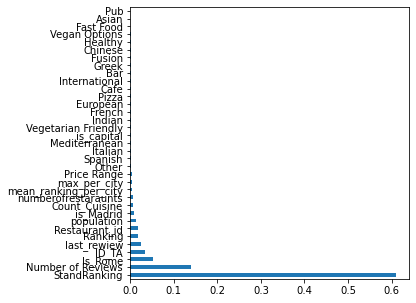

In [175]:
model_func(data.drop(columns=['City', 'Cuisine Style', 'URL_TA', 'country', 'Reviews'
                              ]))

In [177]:
data.drop(columns=['City', 'Cuisine Style','URL_TA','country'
])

,Restaurant_id,Ranking,Price Range,Number of Reviews,Reviews,ID_TA,sample,Rating,Is_Rome,is_Madrid,...,Welsh,Arabic,Count_Cuisine,last_rewiew,is_capital,population,numberofrestaraunts,mean_ranking_per_city,max_per_city,StandRanking
0,0,12963.0,2,4.0,"[[], []]",10746918,0,0.0,0,0,...,0,0,2,5.036953,1,2148000,16684,6938.557138,13986.0,0.430748
1,1,106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",6674944,0,0.0,0,0,...,0,0,5,4.430817,1,631000,1478,564.231579,1141.0,-0.401605
2,2,810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",13129638,0,0.0,0,0,...,0,0,1,4.110874,1,488000,1852,885.130201,1766.0,-0.042543
3,3,1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",680417,0,0.0,0,0,...,0,0,5,4.418841,1,8899000,19374,8169.707354,16444.0,-0.395324
4,4,37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",1112354,0,0.0,0,0,...,0,0,6,2.944439,1,424000,1201,462.428947,889.0,-0.478548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,499,500.0,2,79.0,"[['The real Italian experience!', 'Wonderful f...",2104414,1,4.5,0,0,...,0,0,4,4.290459,0,1352000,7000,3106.027840,6275.0,-0.415303
49996,6340,6341.0,2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",1800036,1,3.5,0,0,...,0,0,5,4.219508,1,2148000,16684,6938.557138,13986.0,-0.042725
49997,1649,1652.0,2,4.0,"[['Good by swedish standards', 'A hidden jewel...",947615,1,4.5,0,0,...,0,0,2,6.175867,1,974000,2882,1237.482091,2464.0,0.168230
49998,640,641.0,2,70.0,"[['Underground restaurant', 'Oldest Restaurant...",1100838,1,4.0,0,0,...,0,0,5,5.442418,1,1708000,3040,1055.193514,2154.0,-0.192290


Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

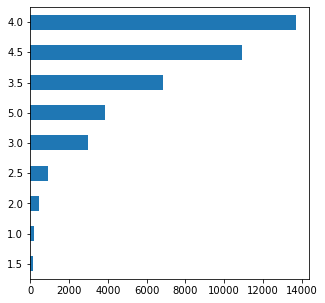

In [178]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

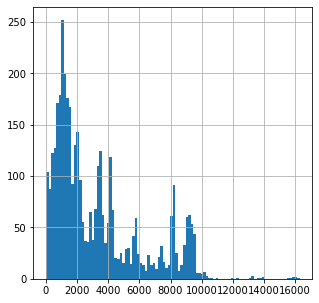

In [179]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

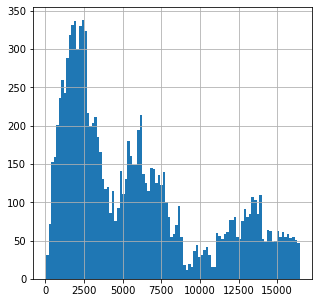

In [181]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [240]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
#df_train = pd.read_csv('main_task.csv')
#df_test = pd.read_csv('kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [241]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df_output = df_input.copy()

    # ################### 1. Предобработка ##############################################################
    # убираем не нужные для модели признаки

    # ################### 2. NAN ##############################################################
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...

    # df_output['Number of Reviews'] = df_output['Number of Reviews'].fillna(
    # df_output['Number of Reviews'].median())#+

    df_output['Price Range'] = df_output['Price Range'].fillna('$$ - $$$')
    #df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna('Other')
    #df_output['ID_TA'] = df_output.ID_TA.apply(lambda x: int(x[1:]))
    # тут ваш код по обработке NAN
    # ....

    # ################### 3. Encoding ##############################################################
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    # cities=pd.get_dummies(df_output['City'],dummy_na=True)
    #df_output=pd.concat([cities, df_output], axis=1)
    df_output['Is_Rome'] = df_output['City'].apply(
        lambda x: 1 if x == 'Rome' else 0)
    df_output['is_Madrid'] = df_output['City'].apply(
        lambda x: 1 if x == 'Madrid' else 0)

    # тут ваш код не Encoding фитчей

    df_output['Price Range'] = df_output['Price Range'].apply(
        lambda x: 2 if x == '$$ - $$$' else 1 if x == '$' else 3)

    # df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(
    # lambda x: str(x)[1:-1].replace("'", '') if not pd.isnull(x) else x)
    df_output['Restaurant_id'] = df_output.Restaurant_id.apply(
        lambda x: int(str(x[3:])))

    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    df_output['Count_Cuisine'] = df_output['Cuisine Style'].apply(
        lambda x: len(str(x).split(', ')))

    data_rev = df_output.copy()
    data_rev = data_rev[['Reviews']]
    data_rev = data_rev.apply(Reviews_class, axis=1)
    df_output = pd.concat(
        [df_output, data_rev.loc[:, ['feed_polarity1', 'feed_subjectivity1']]], axis=1)

    pattern = re.compile('\d\d?/\d\d?/\d+')
    df_output = df_output.apply(time, axis=1)
    df_output['last_rewiew'] = df_output['last_rewiew'].fillna(
        df_output['last_rewiew'].quantile())
    df_output['last_rewiew'] = pd.to_timedelta(
        (max(df_output['last_rewiew'])-df_output['last_rewiew'])).apply(lambda x: x.days)

    df_output = df_output.apply(city_stats, axis=1)
    df_output = pd.get_dummies(df_output, columns=['country', ], dummy_na=True)

    mean_per_city = df_output.groupby('City')['Ranking'].mean()
    df_output['mean_ranking_per_city'] = df_output['City'].apply(
        lambda x: mean_per_city[x])
    #  масмимальный ранкинг для каждого города
    max_per_city = df_output.groupby('City')['Ranking'].max()
    df_output['max_per_city'] = df_output['City'].apply(
        lambda x: max_per_city[x])


# стандартизация
    df_output['StandRanking'] = (
        df_output['Ranking'] - df_output['mean_ranking_per_city']) / df_output['max_per_city']
    df_output['StandRanking_test'] = round(df_output['StandRanking'], 2)
    df_output['Number of Reviews'] = df_output.groupby(
        ['StandRanking_test'])['Number of Reviews'].apply(lambda x: x.fillna(x.mean()))

    # ################### 5. Clean ####################################################
    # убираем признаки которые еще не успели обработать,
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [
        s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis=1, inplace=True)
    df_output.drop(columns=['StandRanking_test',
                            'Restaurant_id'], inplace=True)

    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [242]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,Is_Rome,is_Madrid,Count_Cuisine,feed_polarity1,feed_subjectivity1,...,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_The Czech Republic,country_The Netherlands,country_nan,mean_ranking_per_city,max_per_city,StandRanking
12926,2241.0,2,3.000000,1,4.5,0,0,1,0.000000,0.000000,...,0,0,0,0,0,0,0,1867.330298,3717.0,0.100530
27996,6388.0,2,6.000000,1,3.5,0,0,1,0.750000,0.675000,...,0,1,0,0,0,0,0,3879.422680,7796.0,0.321777
38924,1076.0,2,7.000000,1,4.5,0,0,1,0.000000,0.000000,...,0,0,0,0,0,0,0,1370.297817,2763.0,-0.106514
27669,3706.0,2,33.582393,1,3.0,0,0,1,-0.075000,0.833333,...,0,0,0,0,1,0,0,2086.979626,4188.0,0.386586
20776,2351.0,2,652.000000,1,3.0,0,0,6,0.200000,0.500000,...,0,0,0,0,1,0,0,2086.979626,4188.0,0.063042
8896,1361.0,2,12.000000,0,0.0,0,0,1,-0.083333,0.283333,...,0,0,0,0,0,0,0,982.147741,1964.0,0.192898
48621,1071.0,2,11.000000,1,5.0,0,0,1,-0.200000,0.750000,...,0,0,0,0,0,0,0,752.034268,1484.0,0.214936
9830,2334.0,2,327.000000,0,0.0,0,1,3,0.000000,0.000000,...,0,1,0,0,0,0,0,4388.516391,8809.0,-0.233229
29160,1881.0,2,23.000000,1,4.5,0,0,1,0.000000,0.000000,...,0,1,0,0,0,0,0,3879.422680,7796.0,-0.256339
30638,10110.0,2,5.000000,1,4.5,0,0,1,0.500000,0.600000,...,0,0,0,0,0,0,0,8169.707354,16444.0,0.117994


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1756875

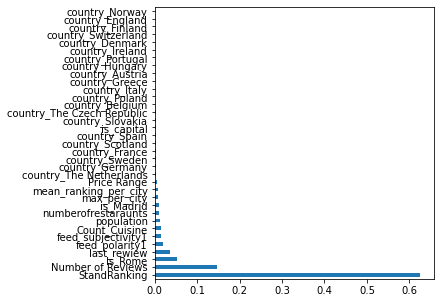

In [260]:
model_func(df_preproc)

In [245]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Ranking                     50000 non-null  float64
 1   Price Range                 50000 non-null  int64  
 2   Number of Reviews           50000 non-null  float64
 3   sample                      50000 non-null  int64  
 4   Rating                      50000 non-null  float64
 5   Is_Rome                     50000 non-null  int64  
 6   is_Madrid                   50000 non-null  int64  
 7   Count_Cuisine               50000 non-null  int64  
 8   feed_polarity1              50000 non-null  float64
 9   feed_subjectivity1          50000 non-null  float64
 10  last_rewiew                 50000 non-null  int64  
 11  is_capital                  50000 non-null  int64  
 12  population                  50000 non-null  int64  
 13  numberofrestaraunts         500

In [246]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [247]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [248]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 40), (40000, 40), (40000, 39), (32000, 39), (8000, 39))

# Model 
Сам ML

In [249]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [250]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [251]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)
y_pred = round_of_rating(y_pred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [252]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1753125


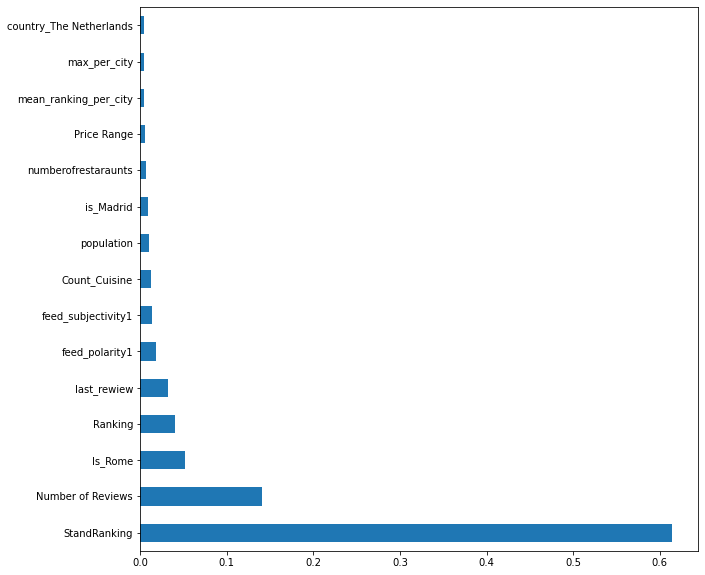

In [253]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [254]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Is_Rome,is_Madrid,Count_Cuisine,feed_polarity1,feed_subjectivity1,last_rewiew,...,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_The Czech Republic,country_The Netherlands,country_nan,mean_ranking_per_city,max_per_city,StandRanking
2007,138.0,2,58.0,0.0,0,0,2,0.1500,0.700,144,...,1,0,0,0,0,0,0,234.509009,468.0,-0.206216
198,4502.0,2,5.0,0.0,0,1,4,0.0000,0.000,153,...,0,1,0,0,0,0,0,4388.516391,8809.0,0.012883
5422,3643.0,2,106.0,0.0,0,0,3,0.2750,0.575,274,...,0,0,0,0,0,0,0,6938.557138,13986.0,-0.235633
8266,2670.0,2,12.0,0.0,0,0,1,0.2000,0.200,162,...,0,0,0,0,0,0,0,1867.330298,3717.0,0.215946
920,1948.0,1,10.0,0.0,0,0,2,0.0000,0.000,277,...,0,0,0,0,0,1,0,1591.589650,3254.0,0.109530
2699,404.0,3,91.0,0.0,0,0,4,0.0000,0.000,13,...,0,0,0,0,0,0,0,1541.901826,3006.0,-0.378544
8984,678.0,2,98.0,0.0,0,0,8,0.9375,0.900,105,...,0,0,0,0,1,0,0,2086.979626,4188.0,-0.336433
3217,10426.0,2,7.0,0.0,0,0,1,1.0000,1.000,1962,...,0,0,0,0,0,0,0,6938.557138,13986.0,0.249352
7627,627.0,2,128.0,0.0,0,0,7,0.9000,1.000,59,...,0,0,0,0,0,0,0,972.127990,1960.0,-0.176086
6127,984.0,2,35.0,0.0,0,0,5,1.0000,1.000,189,...,0,0,0,0,0,0,0,3106.027840,6275.0,-0.338172


In [255]:
test_data = test_data.drop(['Rating'], axis=1)

In [256]:
sample_submission

,Restaurant_id,Rating
0,id_0,3.085
1,id_1,4.185
2,id_2,4.610
3,id_3,4.205
4,id_4,4.530
...,...,...
9995,id_9995,4.505
9996,id_9996,4.140
9997,id_9997,3.085
9998,id_9998,4.345


In [257]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [258]:
predict_submission

array([3.06 , 4.115, 4.49 , ..., 3.045, 4.37 , 4.32 ])

In [261]:
sample_submission['Rating'] = predict_submission
sample_submission['Rating'] = round_of_rating(sample_submission['Rating'])
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.0
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
